In [1]:
import functions as f
import dictionaries as di


('5a', '7a', '6b')


In [3]:
from functions import load_songs_from_xml, random_sample_df, reverse_dictionary, calculate_new_tempo, nml_key_int_to_name
from dictionaries import harmonic_to_note

In [4]:
import importlib as imp

In [5]:
imp.reload(di)
from dictionaries import harmonic_to_note
note_to_harmonic = reverse_dictionary(harmonic_to_note)

In [6]:
imp.reload(f)

from functions import load_songs_from_xml, random_sample_df, reverse_dictionary

('5a', '7a', '6b')


In [71]:
file = "BREAK_ALL.nml"
file = "BreakBeat not listened.nml"

df = load_songs_from_xml(file)

In [72]:
sampled_df = random_sample_df(df, 70)

In [80]:
# Assuming df is your original DataFrame and calculate_new_tempo is defined
import pandas as pd 
SEMITONES = [-2, -1, 1, 2]
bpm_semitone_threshold = 0.25

# List to hold the new rows
new_rows = []

# Iterate over each row in the DataFrame
for index, row in sampled_df.iterrows():
    for semitone_change in SEMITONES:
        # Calculate the new tempo for the current semitone change
        new_tempo = calculate_new_tempo(row['BPM'], semitone_change)
        
        # Create a new row with the same data as the current row, but with the updated tempo
        new_row = row.copy()
        new_row['BPM'] = new_tempo
        # Adjust Musical_Key_Int and ensure it wraps correctly within 1-24 range
        new_key_int = (row['Musical_Key_Int'] - 1 + semitone_change) % 24 + 1
        new_row['Musical_Key_Int'] = new_key_int
        new_row["Musical_Key"] = nml_key_int_to_name(int(new_key_int)) if new_key_int else ""
        new_row["Harmonic_Key"] = note_to_harmonic[new_row["Musical_Key"]] if new_row["Musical_Key"] else ""
        new_row["Kind"] = "Calculated"
        new_row["BPM_max"] = calculate_new_tempo(new_tempo, bpm_semitone_threshold)
        new_row["BPM_min"] = calculate_new_tempo(new_tempo, -bpm_semitone_threshold)
        
        # Optionally, update the Musical_Key and Harmonic_Key based on the semitone change
        
        # Add the new row to the list
        new_rows.append(new_row)

# Create a new DataFrame from the list of new rows
new_df = pd.DataFrame(new_rows)

# Reset the index of the new DataFrame
new_df.reset_index(drop=True, inplace=True)

# Now new_df contains the original data with updated tempos for each semitone change in SEMITONES

In [81]:
df_combined = pd.concat([sampled_df, new_df], ignore_index=True)

In [75]:
row_base.Harmonic_Key in f.get_classic_neighbours("12a")

False

In [76]:
row_base.Harmonic_Key

'3a'

In [82]:
node_list = set(sampled_df.ID)
edge_list = []     
for row_base in df_combined.itertuples():
    for row_to_compare in df_combined.itertuples():
        if row_base.ID == row_to_compare.ID:
            None
        else:
            # first filter, song is whennever between ranges? 
            if row_base.BPM_max >= row_to_compare.BPM and row_base.BPM_min <= row_to_compare.BPM:
                # only a temporary function:
                if row_base.Musical_Key_Int == row_to_compare.Musical_Key_Int:
                    edge_list.append((row_base.ID, row_to_compare.ID))
                else:
                    None
                if row_to_compare.Harmonic_Key in f.get_classic_neighbours(row_base.Harmonic_Key):    
                    #print(row_base.ID, row_to_compare.ID)
                    edge_list.append((row_base.ID, row_to_compare.ID))
                else:
                    None
            else:
                None

In [83]:
import networkx as nx

# Assuming 'edge_list' is already defined as shown in your example

# Create a graph from the edge list
G = nx.DiGraph()
G.add_edges_from(edge_list)

# Now, you can access edges connected to a specific node
node_id = list(G.nodes())[5]  # Example node ID
connected_nodes = list(G.successors(node_id))

print(f"Nodes directly connected to node {node_id}: {connected_nodes}")

Nodes directly connected to node 1413: [748, 693, 1117, 1309, 901, 16, 897, 996, 1422, 77, 100, 708, 160, 1390, 1389]


In the context of directed graphs, such as the one represented by a DiGraph object in NetworkX, the "in-degree" of a node refers to the number of edges coming into that node from other nodes. More specifically, if you have a directed edge from node A to node B, this contributes to the in-degree of node B.

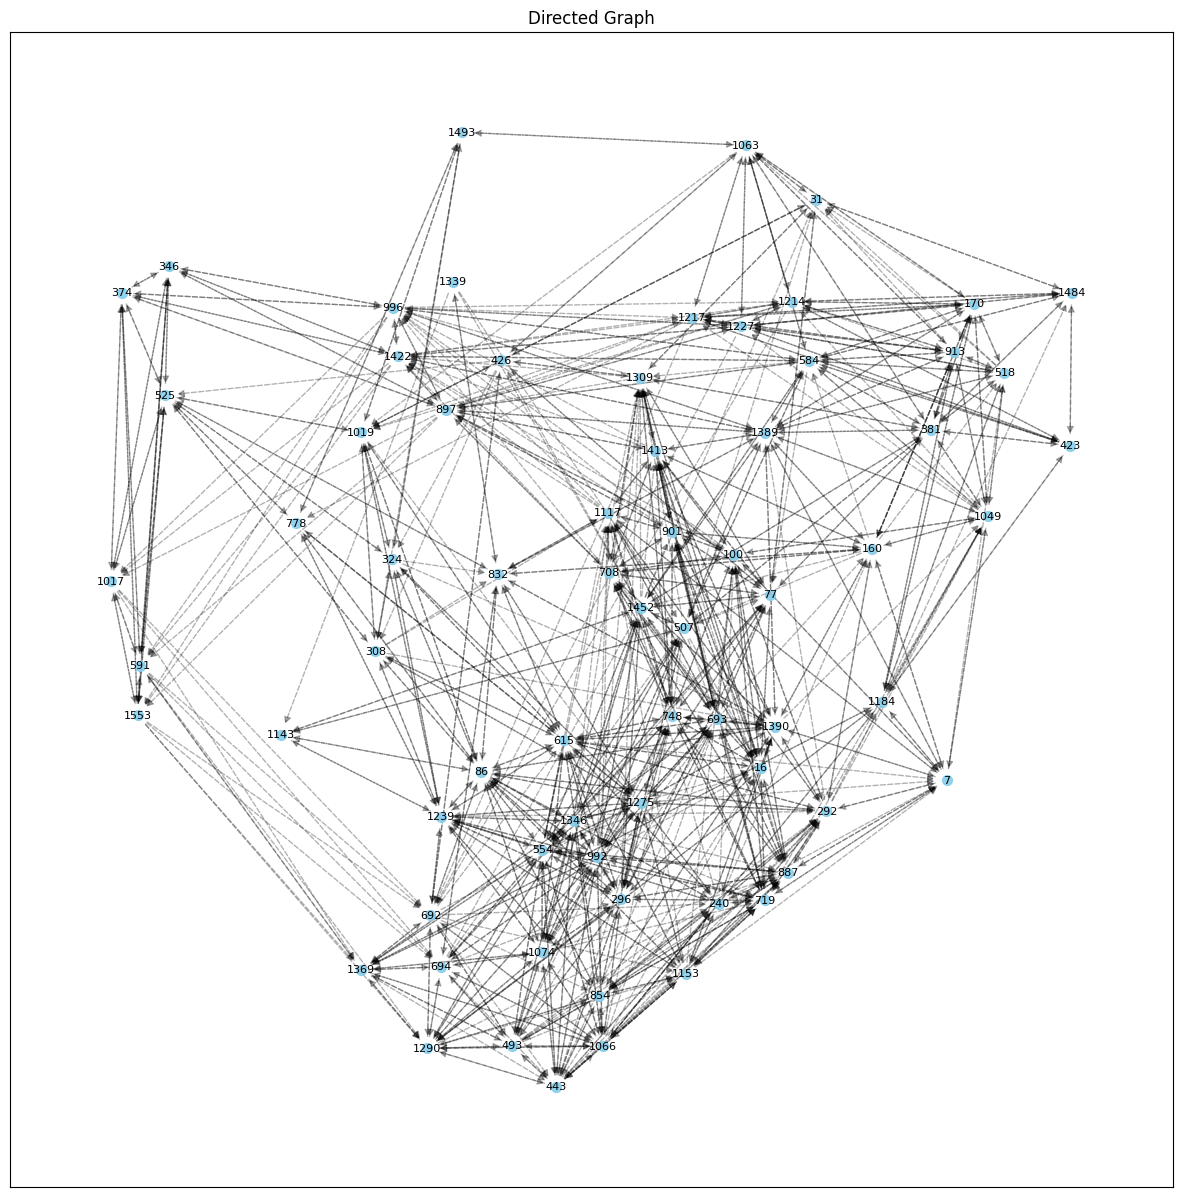

In [84]:
f.plot_a_graph(f.keep_largest_cluster(G))

In [87]:
f.get_classic_neighbours("10a")

('9a', '11a', '10b')

In [89]:
# Assuming G is your directed graph (DiGraph)
import random 

def random_unique_path(G, path_length):
    if len(G) < path_length:
        raise ValueError("Graph has fewer nodes than the desired path length.")
    
    # Start from a random node
    path = [random.choice(list(G.nodes()))]
    
    # Try to find a path with the specified length
    while len(path) < path_length:
        # Get the neighbors of the last node in the path
        neighbors = list(G.successors(path[-1]))
        # Filter out neighbors that are already in the path
        neighbors = [node for node in neighbors if node not in path]
        
        if not neighbors:
            # If there are no neighbors that haven't been visited, start over
            path = [random.choice(list(G.nodes()))]
        else:
            # Randomly select one of the unvisited neighbors
            path.append(random.choice(neighbors))
    
    return path

# Generate a random unique path of 20 nodes
path_length = 20
random_path = random_unique_path(f.keep_largest_cluster(G), path_length)

print("Random unique path:", random_path)

Random unique path: [719, 1413, 708, 693, 887, 7, 292, 100, 897, 1217, 1063, 913, 160, 518, 1049, 170, 381, 1452, 1389, 1390]


In [90]:
for i in random_path:
    #print(df.loc[df.ID == i, ["Title", "BPM", "Musical_Key", "Kind"]])
    display(df.loc[df.ID == i])

,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
718,719,Groove allegiance,Organ Dementia,//DJ//ALBUMOK//[torrents.ru]_Breaks_Pack_Febru...,,Enjoy!,129,133.038481,127.030677,14,,Dm,7a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
1412,1413,None,Construkt,//DJ//SPOTIFY//YOUTUBE//Construkt.mp3,,None,139,143.271751,136.801829,22,,Bbm,3a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
707,708,Etostone,Meko,//DJ//ALBUMOK//[torrents.ru]_Breaks_Pack_Febru...,,Enjoy!,131,135.068942,128.969445,21,,Am,8a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
692,693,RIBS & IG88,Fight,//DJ//ALBUMOK//[torrents.ru]_Breaks_Pack_Febru...,,None,137,141.223255,134.845839,22,,Bbm,3a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
886,887,Deekline And Wizard,Angels (Ft Yolanda) (Radio Edit),//DJ//ALBUMOK//[torrents.ru]_breaks_pack_march...,,8=D~,129,133.016276,127.009474,14,,Dm,7a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
6,7,King Unique,2 The Left (Stanton Warriors Remix),//DJ//BREAKBEAT//King Unique - 2 The Left (Sta...,,None,131,134.828792,128.74014,19,,Gm,6a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
291,292,Embliss,Kaleido (Retroid Remix),//DJ//ALBUMOK//Morphosis Records//[MORPH007] E...,1,Morphosis Records / MORPH007,129,133.038466,127.030662,19,,Gm,6a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
99,100,Crisp Biscuit,Break Of Dawn,//DJ//ALBUMOK//Crisp Biscuit//[CB-17] Crisp Bi...,,None,131,134.243822,128.181586,14,,Dm,7a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
896,897,Dj Hero,I'm In Control (Original Mix),//DJ//ALBUMOK//[torrents.ru]_breaks_pack_march...,,None,134,137.132133,130.939466,21,,Am,8a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
1216,1217,None,2020-03-27_12h32m47,//DJ//RECORDS//2020-03-27_12h32m47.wav,,None,137,141.225457,134.847942,14,,Dm,7a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
1062,1063,C-Vaughn & J-Virtue Ft Annalyze,Straight Up (Original Mix),//DJ//ALBUMOK//[torrents.ru]_breaks_pack_march...,,None,138,141.225675,134.84815,19,,Gm,6a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
912,913,None,04-dylan_rhymes_feat_pablo_decoder-i_am_sweet_...,//DJ//ALBUMOK//[torrents.ru]_breaks_pack_march...,1,None,135,138.158724,131.919697,19,1,Gm,6a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
159,160,Drumattic Twins,Crazy Love (Jem Stone's Love A,//DJ//ALBUMOK//Drumattic Twins-Deep Throat_EP-...,,Enjoy!,132,135.085479,128.985235,12,,Cm,5a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
517,518,Don Vitalo,Feeling Funky (Original Mix),//DJ//ALBUMOK//Weekend Music//[WM035] Don Vita...,,Sponsored By Canada.,127,130.99171,125.076334,18,,Gbm,11a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
1048,1049,Stanton Warriors,Precinct (Original Mix),//DJ//ALBUMOK//[torrents.ru]_breaks_pack_march...,1,Breaks,133,137.130306,130.937721,19,2,Gm,6a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
169,170,Elite Force,Vapour Eyes,//DJ//ALBUMOK//Elite Force - No Turning Back [...,,None,135,138.159973,131.92089,19,,Gm,6a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
380,381,Brothers Funk,I Really Believe,//DJ//ALBUMOK//VA - Flavored Beats//(1999) VA ...,,None,136,139.209956,132.923457,12,,Cm,5a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
1451,1452,None,Dj Gumbee - Sweet Soul Brother,//DJ//SPOTIFY//YOUTUBE//Dj Gumbee - Sweet Soul...,,None,135,139.144089,132.860565,17,,Fm,4a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
1388,1389,None,Bombin' the Subway (12' Mix),//DJ//SPOTIFY//YOUTUBE//Bombin- the Subway (12...,,None,133,136.118003,129.971133,12,,Cm,5a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
1389,1390,None,Boundarie Hunters - Be Bop,//DJ//SPOTIFY//YOUTUBE//Boundarie Hunters - Be...,,None,130,133.275602,127.25709,12,,Cm,5a,Base
